In [1]:
install.packages("RPostgreSQL")
library(RPostgreSQL)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Loading required package: DBI



In [3]:
db_connection <- DBI::dbConnect(dbDriver(drvName = "PostgreSQL"), dbname = Sys.getenv("DB_NAME"), host=Sys.getenv("HOST_NAME"), port="5432", user=Sys.getenv("POSTGRES_USERNAME"), password=Sys.getenv("POSTGRES_PASSWORD"))  

# List all projects
sql_all_projects = "SELECT id::text, name, created_at FROM projects"
dbGetQuery(db_connection, sql_all_projects)

,id,name,created_at
,<chr>,<chr>,<dttm>
1,1628ba4d-8900-41a6-88a3-2c0868b53566,Sock Shop,2021-04-15 16:47:07
2,a0756ff7-13ae-4fec-99b9-2ca793e6b25c,Train ticket,2021-04-15 16:48:37


In [4]:
project_id = "a0756ff7-13ae-4fec-99b9-2ca793e6b25c"

In [6]:
sql_operational_profile = "
    SELECT users, frequency FROM operational_profile_observations 
        WHERE operational_profile = (SELECT id FROM operational_profiles WHERE project = ?project)"
operational_profile <- dbGetQuery(db_connection, sqlInterpolate(db_connection, sql_operational_profile, project = project_id))

operational_profile

<0 x 0 matrix>

In [7]:
sql_all_tests = "SELECT id::text, name, created_at FROM tests WHERE project = ?project"
dbGetQuery(db_connection, sqlInterpolate(db_connection, sql_all_tests, project = project_id))

,id,name,created_at
,<chr>,<chr>,<dttm>
1,337ddfc4-d4dc-4a9b-bb15-81e8a84d300f,202104151616-t1-test1,2021-04-15 16:16:00
2,ced50b05-b650-4d8c-bbd0-015228bdde60,202104151624-t1-test2,2021-04-15 16:24:52
3,ac42e03f-5796-499a-aad9-8bdac04b8282,202104151737-t1-test1,2021-04-15 17:37:38
4,1c4b2b95-5910-44eb-9269-8b3cbbd0486a,202104151745-t1-test2,2021-04-15 17:45:32
5,cee9200b-82c8-435b-ab14-ee37edfd36cf,202104281526-tt-test2,2021-04-28 15:26:50


In [8]:
sql_all_test_sets = "SELECT id::text, name FROM test_sets WHERE project = ?project"
dbGetQuery(db_connection, sqlInterpolate(db_connection, sql_all_test_sets, project = project_id))

,id,name
,<chr>,<chr>
1,01ae9f1c-a1cc-4309-a4d8-2ae9ded2bbb2,a
2,ee2dc400-9a92-4f00-89c5-8fbda4e4a57e,b


In [9]:
sql_all_items = "SELECT id::text, name FROM items WHERE project = ?project"
dbGetQuery(db_connection, sqlInterpolate(db_connection, sql_all_items, project = project_id))

,id,name
,<chr>,<chr>
1,989a0d57-c824-4ff5-ae87-3df008b80257,home_expected
2,47eb2e91-f863-4c0b-a8d2-66f5ce8f0dae,search_ticket_expected


In [10]:
sql_all_data = "
    SELECT tests.id::text AS test_id, test_sets.id::text AS test_set_id, results.created_at::timestamp, metrics.abbreviation AS metric, items.name AS item_name, results.value AS item_value
        FROM results 
        INNER JOIN tests ON results.test = tests.id
        INNER JOIN items ON results.item = items.id
        INNER JOIN metrics ON results.metric = metrics.id 
        INNER JOIN test_set_tests ON test_set_tests.test = tests.id
        INNER JOIN test_sets ON (test_sets.id = test_set_tests.test_set AND test_sets.project = tests.project)
        WHERE metrics.abbreviation='mrt' AND items.name='search_ticket_expected' AND tests.project = ?project"
all_data = dbGetQuery(db_connection, sqlInterpolate(db_connection, sql_all_data, project = project_id))

all_data

,test_id,test_set_id,created_at,metric,item_name,item_value
,<chr>,<chr>,<dttm>,<chr>,<chr>,<dbl>
1,337ddfc4-d4dc-4a9b-bb15-81e8a84d300f,01ae9f1c-a1cc-4309-a4d8-2ae9ded2bbb2,2021-04-15 16:16:00,mrt,search_ticket_expected,2
2,ced50b05-b650-4d8c-bbd0-015228bdde60,ee2dc400-9a92-4f00-89c5-8fbda4e4a57e,2021-04-15 16:24:52,mrt,search_ticket_expected,160
3,ac42e03f-5796-499a-aad9-8bdac04b8282,01ae9f1c-a1cc-4309-a4d8-2ae9ded2bbb2,2021-04-15 17:37:38,mrt,search_ticket_expected,250
4,1c4b2b95-5910-44eb-9269-8b3cbbd0486a,ee2dc400-9a92-4f00-89c5-8fbda4e4a57e,2021-04-15 17:45:32,mrt,search_ticket_expected,150
5,cee9200b-82c8-435b-ab14-ee37edfd36cf,ee2dc400-9a92-4f00-89c5-8fbda4e4a57e,2021-04-28 15:26:50,mrt,search_ticket_expected,170


In [11]:
library(ggplot2)

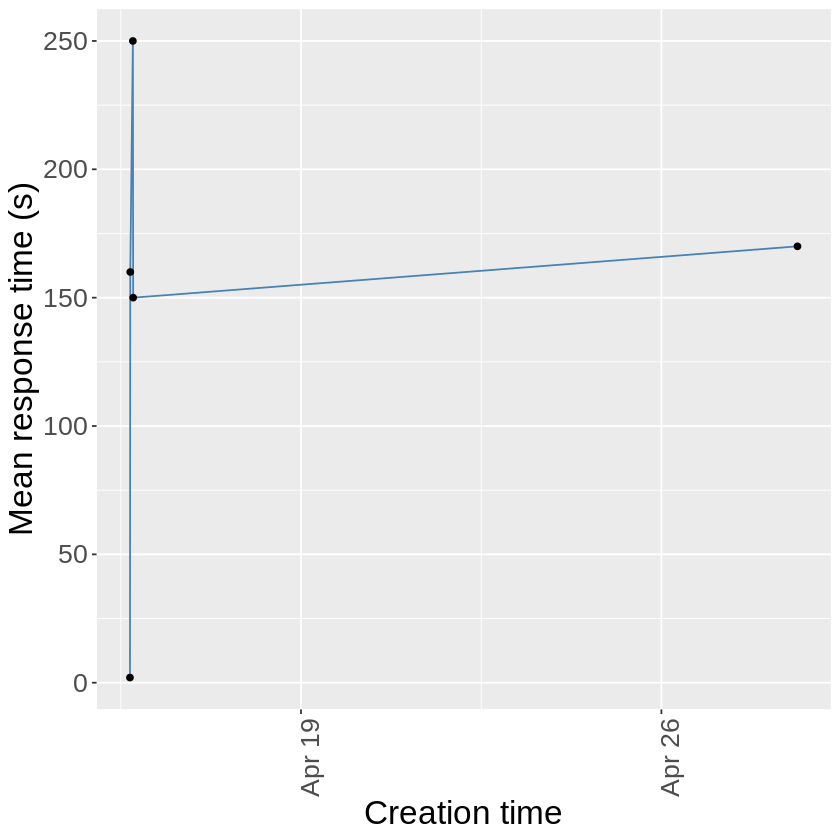

In [13]:
ggplot(all_data, aes(x=created_at, y=item_value)) + 
geom_line(color="steelblue") + 
geom_point() +
theme(text = element_text(size=20), axis.text.x = element_text(angle=90, hjust=1)) +
labs(y="Mean response time (s)", x = "Creation time")

In [14]:
DBI::dbDisconnect(db_connection)

[1] TRUE